In [1]:
import pandas as pd
import zipfile
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils



In [2]:
zf = zipfile.ZipFile("playground-series-s3e26.zip")

In [3]:
zf.namelist()

['sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
df_train = pd.read_csv(zf.open("train.csv"))
df_test = pd.read_csv(zf.open("test.csv"))

In [5]:
df_train.sample(5)
#df_train.describe()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
3927,3927,2576,D-penicillamine,17323,F,N,N,N,N,1.2,174.0,3.83,59.0,976.0,125.55,96.0,221.0,10.3,3.0,C
5638,5638,4039,D-penicillamine,14684,F,N,N,N,N,0.7,256.0,3.40,42.0,1132.0,74.40,94.0,371.0,10.0,1.0,D
4009,4009,1217,D-penicillamine,25546,F,N,Y,N,N,0.8,172.0,3.54,23.0,696.0,57.35,57.0,269.0,11.0,4.0,D
7846,7846,3069,Placebo,16718,F,N,N,N,N,0.6,273.0,3.65,48.0,794.0,52.70,214.0,336.0,9.6,2.0,C
1989,1989,264,Placebo,20284,F,Y,Y,N,Y,12.6,178.0,3.44,138.0,918.0,147.25,91.0,126.0,11.8,4.0,D


In [6]:
#coding Sex, Ascites, Hepatomegaly, Spiders, Edema and Drug into numbers
from sklearn.preprocessing import LabelEncoder


df_train_encoded = df_train.copy()

categorical_vars = ['Drug', 'Sex', "Ascites", 'Hepatomegaly', 'Spiders', 'Edema', 'Status']

label_encoders = {}

for column in categorical_vars:
    le = LabelEncoder()
    df_train_encoded[column] = le.fit_transform(df_train[column])
    label_encoders[column] = le

df_train_encoded.loc[[166]]

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
166,166,762,0,15056,0,0,1,0,0,14.4,1712.0,3.65,89.0,3681.0,158.1,139.0,297.0,10.0,3.0,1


<Axes: >

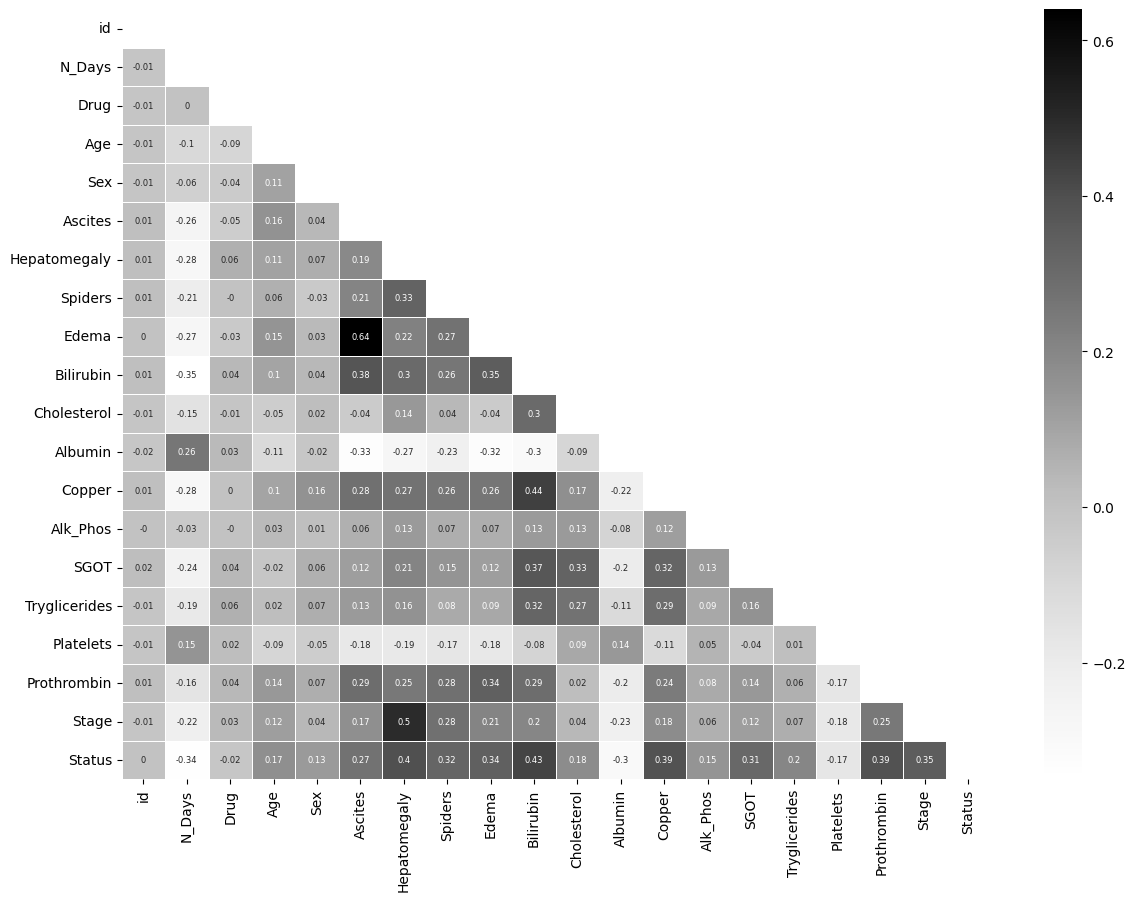

In [7]:
#generating a correlation matrix

matrix = df_train_encoded.corr().round(2)


excluded_columns = ['id']
#sns.heatmap(matrix , annot=True)
fig, axes = plt.subplots(figsize=(14, 10))
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(matrix, mask=mask, linewidths=.5, cmap='Greys', annot=True, annot_kws={"size": 6})



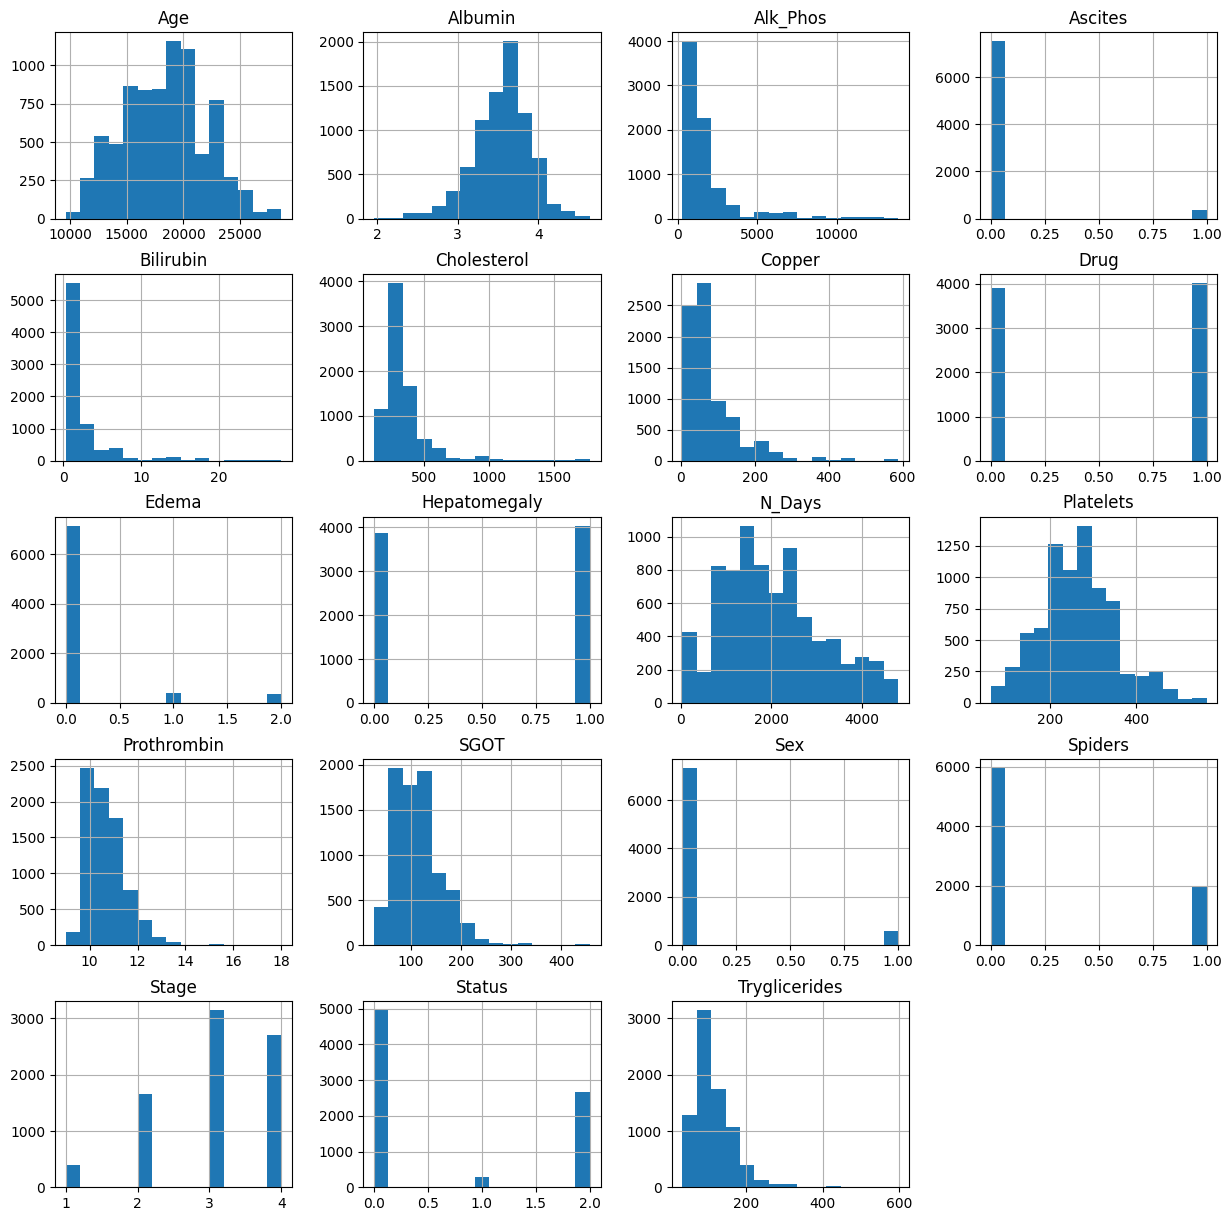

In [8]:
#Histograms of encoded data

exclude = ['id']
#The following ".loc[:, encoded_df.columns.difference(exclude)]" excludes id from being plotted on the histogram figure below

df_train_encoded.loc[:, df_train_encoded.columns.difference(exclude)].hist(figsize=(15,15), bins = 15)
plt.title("Features")
plt.show()

In [9]:
#training a RF model

#features
x = df_train_encoded.drop(['id', 'Status'], axis=1)

#labels
y = df_train_encoded.Status

In [10]:
#hyperparameters
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 25)



rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_log_loss', random_state=42)


rf_model.fit(x_train, y_train)

best_params = rf_model.best_params_   

best_model = rf_model.best_estimator_
y_pred = best_model.predict_proba(x_test)



print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

print(log_loss(y_test, y_pred))
#print(rf_model.score(x_train,y_train))

Unique classes in y_test: [0 1 2]
Unique classes in y_pred: [0.00000000e+00 5.81395349e-05 1.42857143e-04 ... 9.98607143e-01
 9.99857143e-01 1.00000000e+00]
0.4489402689649329


In [18]:
#Check feature Importance
importances = best_model.feature_importances_
columns = x.columns
i = 0

while i< len(columns):
    print (f" The importance of feature '{columns[i]}' is {round(importances[i]*100, 2)}%.")
    i += 1

 The importance of feature 'N_Days' is 14.88%.
 The importance of feature 'Drug' is 0.75%.
 The importance of feature 'Age' is 5.56%.
 The importance of feature 'Sex' is 0.58%.
 The importance of feature 'Ascites' is 0.52%.
 The importance of feature 'Hepatomegaly' is 3.44%.
 The importance of feature 'Spiders' is 1.29%.
 The importance of feature 'Edema' is 1.88%.
 The importance of feature 'Bilirubin' is 17.18%.
 The importance of feature 'Cholesterol' is 5.12%.
 The importance of feature 'Albumin' is 4.76%.
 The importance of feature 'Copper' is 9.51%.
 The importance of feature 'Alk_Phos' is 4.91%.
 The importance of feature 'SGOT' is 6.35%.
 The importance of feature 'Tryglicerides' is 4.31%.
 The importance of feature 'Platelets' is 5.0%.
 The importance of feature 'Prothrombin' is 9.55%.
 The importance of feature 'Stage' is 4.42%.


In [19]:
df_test_encoded = df_test.copy()

categorical_vars = ['Drug', 'Sex', "Ascites", 'Hepatomegaly', 'Spiders', 'Edema']

label_encoders = {}

for column in categorical_vars:
    le = LabelEncoder()
    df_test_encoded[column] = le.fit_transform(df_test[column])
    label_encoders[column] = le

df_test_encoded

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,0,19724,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,0,14975,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,1,13149,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,0,20510,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,0,21904,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13171,2870,1,12279,0,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,13172,1770,1,24803,0,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,13173,3707,0,16990,0,0,1,0,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,13174,1216,1,11773,0,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [20]:

prediction = best_model.predict_proba(df_test_encoded.drop(['id'], axis=1))


In [21]:
df_submission = pd.DataFrame({
    'id':df_test_encoded['id'],
    'Status_C' : prediction[:, 0],
    'Status_CL': prediction [:,1],
    'Status_D': prediction [:,2],


})

In [22]:
df_submission.head(5)

,id,Status_C,Status_CL,Status_D
0,7905,0.663250,0.045470,0.291280
1,7906,0.690036,0.125202,0.184762
2,7907,0.135875,0.048375,0.815750
3,7908,0.953361,0.010917,0.035722
4,7909,0.683786,0.092099,0.224115


In [23]:
df_submission.to_csv('ThirdSubmission_RF_test_size_30.csv', index=False)

: 